In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
import os


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures, MaxAbsScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, SelectFromModel
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D


import warnings
warnings.filterwarnings('ignore')



from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar100.load_data(label_mode='fine')
y_train=y_train.ravel()
y_test=y_test.ravel()

x_train=x_train.astype(np.float32)/255.0;
x_test=x_test.astype(np.float32)/255.0;

print(f"X_train shape : {x_train.shape} , Y_train shape : {y_train.shape}")
print(f"X_test shape : {x_test.shape} , Y_test shape : {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train shape : (50000, 32, 32, 3) , Y_train shape : (50000,)
X_test shape : (10000, 32, 32, 3) , Y_test shape : (10000,)


In [4]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,stratify=y_train,random_state=24)

print(f"X_train shape : {x_train.shape} , Y_train shape : {y_train.shape}")
print(f"X_val shape : {x_val.shape} , Y_val shape : {y_val.shape}")

X_train shape : (45000, 32, 32, 3) , Y_train shape : (45000,)
X_val shape : (5000, 32, 32, 3) , Y_val shape : (5000,)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers,models


def build_custom_cnn(input_shape=(32,32,3),num_classes=100):
    inp=layers.Input(shape=input_shape)


    x=layers.Conv2D(32,(3,3),padding='same',use_bias=False)(inp)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(32,(3,3),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.MaxPooling2D((2,2))(x)
    x=layers.Dropout(0.2)(x)


    x=layers.Conv2D(64,(3,3),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(64,(3,3),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.MaxPooling2D((2,2))(x)
    x=layers.Dropout(0.3)(x)

    x=layers.Conv2D(128,(3,3),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Conv2D(128,(3,3),padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.MaxPooling2D((2,2))(x)
    x=layers.Dropout(0.4)(x)

    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dense(512,use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Dropout(0.5)(x)
    out=layers.Dense(num_classes,activation='softmax')(x)

    return models.Model(inp,out)

input_shape=x_train.shape[1:]
model=build_custom_cnn(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 407,236 (1.55 MB)

 Trainable params: 405,316 (1.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [8]:
from tensorflow.keras import callbacks

es=callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True,verbose=1)
mc=callbacks.ModelCheckpoint('best_custom_cnn.h5',monitor='val_loss',save_best_only=True,verbose=1)
rlr=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,verbose=1)

csv_logger=callbacks.CSVLogger('training_log.csv')

In [9]:
epochs = 60
steps_per_epoch = max(1, x_train.shape[0] // batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[es, mc, rlr, csv_logger]
)

Epoch 1/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0519 - loss: 4.4398
Epoch 1: val_loss improved from inf to 4.56598, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.0520 - loss: 4.4390 - val_accuracy: 0.0400 - val_loss: 4.5660 - learning_rate: 0.0010
Epoch 2/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.1094 - loss: 3.8132
Epoch 2: val_loss did not improve from 4.56598
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.1094 - loss: 3.8132 - val_accuracy: 0.0380 - val_loss: 4.5739 - learning_rate: 0.0010
Epoch 3/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1313 - loss: 3.6478
Epoch 3: val_loss improved from 4.56598 to 3.63407, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.1313 - loss: 3.6475 - val_accuracy: 0.1486 - val_loss: 3.6341 - learning_rate: 0.0010
Epoch 4/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 6:38 1s/step - accuracy: 0.1484 - loss: 3.5100
Epoch 4: val_loss improved from 3.63407 to 3.59323, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.1484 - loss: 3.5100 - val_accuracy: 0.1504 - val_loss: 3.5932 - learning_rate: 0.0010
Epoch 5/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1937 - loss: 3.2976
Epoch 5: val_loss improved from 3.59323 to 3.21892, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.1937 - loss: 3.2974 - val_accuracy: 0.2132 - val_loss: 3.2189 - learning_rate: 0.0010
Epoch 6/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:46 991ms/step - accuracy: 0.1953 - loss: 3.2210
Epoch 6: val_loss improved from 3.21892 to 3.13788, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.1953 - loss: 3.2210 - val_accuracy: 0.2248 - val_loss: 3.1379 - learning_rate: 0.0010
Epoch 7/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2402 - loss: 3.0229
Epoch 7: val_loss did not improve from 3.13788
351/351 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.2403 - loss: 3.0228 - val_accuracy: 0.2156 - val_loss: 3.1601 - learning_rate: 0.0010
Epoch 8/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 12:23 2s/step - accuracy: 0.2812 - loss: 3.0352
Epoch 8: val_loss did not improve from 3.13788
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.2812 - loss: 3.0352 - val_accuracy: 0.2056 - val_loss: 3.2326 - learning_rate: 0.0010
Epoch 9/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2699 - loss: 2.8409
Epoch 9: val_loss improved from 3.13788 to 2.91183, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.2699 - loss: 2.8408 - val_accuracy: 0.2714 - val_loss: 2.9118 - learning_rate: 0.0010
Epoch 10/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 13:55 2s/step - accuracy: 0.3359 - loss: 2.6039
Epoch 10: val_loss improved from 2.91183 to 2.90824, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.3359 - loss: 2.6039 - val_accuracy: 0.2698 - val_loss: 2.9082 - learning_rate: 0.0010
Epoch 11/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3009 - loss: 2.6926
Epoch 11: val_loss improved from 2.90824 to 2.76913, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.3009 - loss: 2.6926 - val_accuracy: 0.2930 - val_loss: 2.7691 - learning_rate: 0.0010
Epoch 12/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:07 2s/step - accuracy: 0.3203 - loss: 2.6188
Epoch 12: val_loss improved from 2.76913 to 2.66173, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.3203 - loss: 2.6188 - val_accuracy: 0.3126 - val_loss: 2.6617 - learning_rate: 0.0010
Epoch 13/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3274 - loss: 2.5720
Epoch 13: val_loss did not improve from 2.66173
351/351 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.3274 - loss: 2.5720 - val_accuracy: 0.2918 - val_loss: 2.8375 - learning_rate: 0.0010
Epoch 14/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:49 998ms/step - accuracy: 0.3672 - loss: 2.5126
Epoch 14: val_loss did not improve from 2.66173
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.3672 - loss: 2.5126 - val_accuracy: 0.2910 - val_loss: 2.8284 - learning_rate: 0.0010
Epoch 15/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3423 - loss: 2.4849
Epoch 15: val_loss improved from 2.66173 to 2.54307, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.3423 - loss: 2.4849 - val_accuracy: 0.3360 - val_loss: 2.5431 - learning_rate: 0.0010
Epoch 16/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:38 966ms/step - accuracy: 0.3672 - loss: 2.2975
Epoch 16: val_loss improved from 2.54307 to 2.52724, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3672 - loss: 2.2975 - val_accuracy: 0.3386 - val_loss: 2.5272 - learning_rate: 0.0010
Epoch 17/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3606 - loss: 2.4221
Epoch 17: val_loss did not improve from 2.52724
351/351 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.3606 - loss: 2.4220 - val_accuracy: 0.3306 - val_loss: 2.6168 - learning_rate: 0.0010
Epoch 18/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.3281 - loss: 2.4871
Epoch 18: val_loss did not improve from 2.52724
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3281 - loss: 2.4871 - val_accuracy: 0.3368 - val_loss: 2.5861 - learning_rate: 0.0010
Epoch 19/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3774 - loss: 2.3357
Epoch 19: val_loss did not improve from 2.52724

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
351/351 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.3774 - loss: 2.3357 - val_accuracy

351/351 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.4050 - loss: 2.2173 - val_accuracy: 0.4126 - val_loss: 2.2205 - learning_rate: 5.0000e-04
Epoch 22/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:22 2s/step - accuracy: 0.4219 - loss: 1.9103
Epoch 22: val_loss improved from 2.22048 to 2.21121, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4219 - loss: 1.9103 - val_accuracy: 0.4148 - val_loss: 2.2112 - learning_rate: 5.0000e-04
Epoch 23/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4110 - loss: 2.1737
Epoch 23: val_loss improved from 2.21121 to 2.12513, saving model to best_custom_cnn.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.4111 - loss: 2.1737 - val_accuracy: 0.4308 - val_loss: 2.1251 - learning_rate: 5.0000e-04
Epoch 24/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:34 956ms/step - accuracy: 0.3516 - loss: 2.3140
Epoch 24: val_loss did not improve from 2.12513
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3516 - loss: 2.3140 - val_accuracy: 0.4302 - val_loss: 2.1296 - learning_rate: 5.0000e-04
Epoch 25/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4277 - loss: 2.1346
Epoch 25: val_loss did not improve from 2.12513
351/351 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.4277 - loss: 2.1347 - val_accuracy: 0.4044 - val_loss: 2.2181 - learning_rate: 5.0000e-04
Epoch 26/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 6:29 1s/step - accuracy: 0.4531 - loss: 2.0585
Epoch 26: val_loss did not improve from 2.12513

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4531 - loss: 2.05

351/351 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.4331 - loss: 2.0718 - val_accuracy: 0.4560 - val_loss: 2.0577 - learning_rate: 2.5000e-04
Epoch 28/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:50 2s/step - accuracy: 0.4766 - loss: 1.9191
Epoch 28: val_loss did not improve from 2.05775
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4766 - loss: 1.9191 - val_accuracy: 0.4522 - val_loss: 2.0763 - learning_rate: 2.5000e-04
Epoch 29/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4401 - loss: 2.0598
Epoch 29: val_loss did not improve from 2.05775
351/351 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.4401 - loss: 2.0597 - val_accuracy: 0.4554 - val_loss: 2.0652 - learning_rate: 2.5000e-04
Epoch 30/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:41 2s/step - accuracy: 0.4453 - loss: 1.9371
Epoch 30: val_loss did not improve from 2.05775

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4453 - loss: 1.9371 

351/351 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.4544 - loss: 2.0065 - val_accuracy: 0.4710 - val_loss: 1.9848 - learning_rate: 1.2500e-04
Epoch 32/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 9:00 2s/step - accuracy: 0.4922 - loss: 2.0709
Epoch 32: val_loss did not improve from 1.98485
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4922 - loss: 2.0709 - val_accuracy: 0.4714 - val_loss: 1.9899 - learning_rate: 1.2500e-04
Epoch 33/60
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4604 - loss: 1.9783
Epoch 33: val_loss did not improve from 1.98485
351/351 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.4604 - loss: 1.9783 - val_accuracy: 0.4538 - val_loss: 2.0776 - learning_rate: 1.2500e-04
Epoch 34/60
  1/351 ━━━━━━━━━━━━━━━━━━━━ 5:38 966ms/step - accuracy: 0.4688 - loss: 2.0540
Epoch 34: val_loss did not improve from 1.98485

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4688 - loss: 2.054

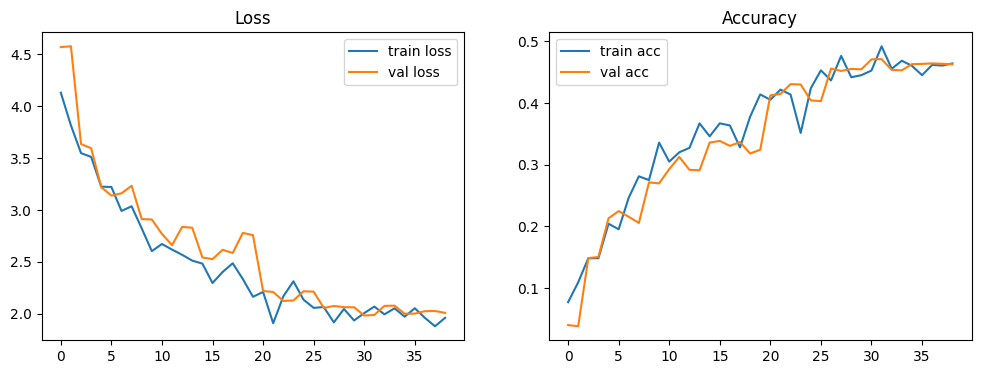

In [10]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='train loss')
    plt.plot(hist['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(hist['accuracy'], label='train acc')
    plt.plot(hist['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

plot_history(history)

In [11]:
model.load_weights('best_custom_cnn.h5')
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

79/79 - 21s - 261ms/step - accuracy: 0.4770 - loss: 1.9276
Test loss: 1.9276, Test accuracy: 0.4770


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(x_test, batch_size=256, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.show()


In [ ]:
model.save('custom_cnn_cifar100_full.h5')
model.save('custom_cnn_cifar100_savedmodel')